# Read data CSV by Spark

In [51]:
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Tạo Spark session
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

# Đọc file CSV
df = spark.read.csv("../../../data/Chiller.csv", header=True, inferSchema=True)
# Hiển thị dữ liệu
df.show()
# Chuyển đổi DataFrame của Spark thành Pandas DataFrame
pandas_df = df.toPandas()

+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+
|               Time|X-Acceleration|Y-Acceleration|Z-Acceleration| X-Velocity| Y-Velocity| Z-Velocity|Composite-Acceleration|Composite-Velocity|Temperature Z|Temperature-XYZ|X-Velocity_predictions|
+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+
|2022-12-01 12:00:00|    15.1796875|      16.15625|    10.4921875| 1.62109375|1.877929688|1.686523438|             17.515625|               3.0|        19.25|          19.25|                 1.621|
|2022-12-01 13:00:00|      16.09375|    15.3515625|     10.421875|1.466796875|1.686523438|1.462890625|               18.9375|          2.671875|        18.75|          18.75|                 1.467|
|2022-12-0

In [52]:
# Hàm xử lý dữ liệu thiếu
def handle_missing_data(df, method="mean_fill"):
    if method == "backward_fill":
        df = df.fillna(method='bfill')
    elif method == "forward_fill":
        df = df.fillna(method='ffill')
    elif method == "mean_fill":
        df = df.fillna(df.mean())
    # Nếu là "no-cleaning", không làm gì cả
    return df

# Áp dụng phương pháp xử lý mean fill
pandas_df = handle_missing_data(pandas_df, "mean_fill")

# Hiển thị dữ liệu sau khi xử lý
print("Dữ liệu sau khi xử lý mean fill:")
print(pandas_df)

Dữ liệu sau khi xử lý mean fill:
                    Time  X-Acceleration  Y-Acceleration  Z-Acceleration  \
0    2022-12-01 12:00:00       15.179688       16.156250       10.492188   
1    2022-12-01 13:00:00       16.093750       15.351562       10.421875   
2    2022-12-01 14:00:00       12.914062       16.296875       11.445312   
3    2022-12-01 15:00:00       17.140625       25.671875       11.890625   
4    2022-12-01 16:00:00       19.671875       20.375000       13.460938   
...                  ...             ...             ...             ...   
1685 2023-03-01 08:00:00       18.312500       18.937500        5.605469   
1686 2023-03-01 09:00:00       15.187500       16.687500        6.039062   
1687 2023-03-01 10:00:00       26.312500       17.921875        6.265625   
1688 2023-03-01 11:00:00       20.500000       18.468750        5.585938   
1689 2023-03-01 12:00:00       14.601562       22.015625        6.626000   

      X-Velocity  Y-Velocity  Z-Velocity  Composite-Ac

In [53]:
# Chọn các cột cần thiết cho mô hình IsolationForest (bỏ qua cột đầu tiên)
features = pandas_df[columns[1:]].values

# Áp dụng PCA để giảm số lượng đặc trưng
pca = PCA(n_components=2)  # Thay đổi số lượng thành phần chính nếu cần
features_pca = pca.fit_transform(features)

In [54]:
# Sử dụng IsolationForest để phát hiện bất thường
model = IsolationForest(contamination=0.1)  # Đặt mức độ bất thường mong muốn
model.fit(features)

# Dự đoán các điểm bất thường
predictions = model.predict(features)

# Thêm cột dự đoán vào DataFrame
pandas_df["anomaly"] = predictions

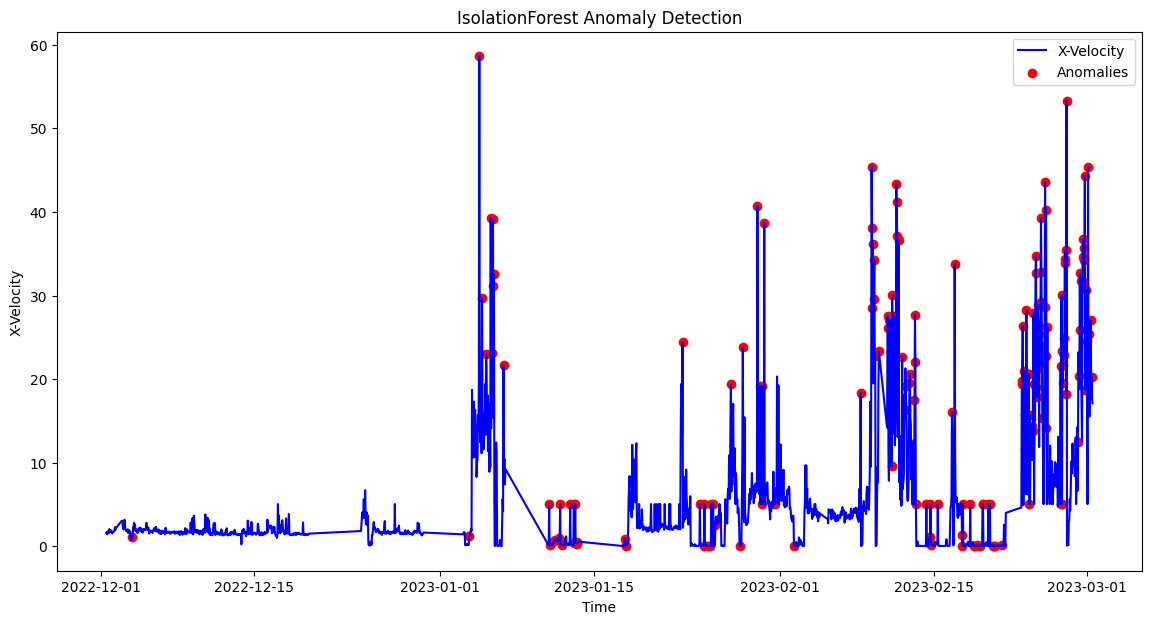

In [55]:
# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column, các điểm bất thường được đánh dấu bằng scatter màu đỏ
plt.figure(figsize=(14, 7))

# Vẽ biểu đồ line cho cột được chọn
plt.plot(pandas_df[timestamp_column], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == -1]
plt.scatter(anomalies[timestamp_column], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(timestamp_column)
plt.ylabel(selected_column)
plt.legend()
plt.title("IsolationForest Anomaly Detection")
plt.show()
